In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 13.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scipy.sparse as sp
import nltk
import numpy as np
import pandas as pd
import json
import unidecode
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, roc_auc_score, accuracy_score, f1_score, precision_recall_fscore_support, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [4]:
nltk.download("rslp")
nltk.download('stopwords')
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
stop = np.unique([unidecode.unidecode(stemmer.stem(w)) for w in stopwords.words('portuguese')])

In [11]:
f = open("/content/drive/MyDrive/Trabalho final BMT/tfidf/idf_stopAndStem.txt", "r")
idfs = np.loadtxt(f)
f.close()
# subclass TfidfVectorizer
class MyVectorizer(TfidfVectorizer):
    # plug our pre-computed IDFs
    TfidfVectorizer.idf_ = idfs

# instantiate vectorizer
vectorizer = MyVectorizer(norm="l1", smooth_idf = True, ngram_range=(1, 1), use_idf=True, stop_words=stop.tolist())

# plug _tfidf._idf_diag
vectorizer._tfidf._idf_diag = sp.spdiags(idfs,
                                         diags = 0,
                                         m = len(idfs),
                                         n = len(idfs))
vectorizer.vocabulary_ = json.load(open('/content/drive/MyDrive/Trabalho final BMT/tfidf/vocabulary_stopAndStem.json', mode = 'r'))

In [15]:
df = pd.read_csv("/content/drive/MyDrive/Trabalho final BMT/Legendas/legenda_categoria.csv", converters={'y': eval})

In [16]:
mlb = MultiLabelBinarizer(sparse_output=True)

In [17]:
df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('y').tolist()),
                index=df.index,
                columns=mlb.classes_))

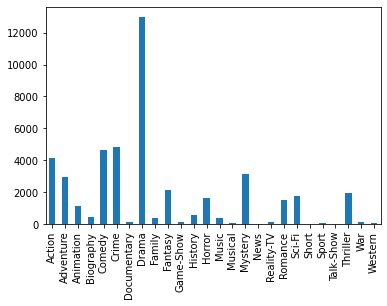

In [ ]:
df[df.columns[2:]].sum().plot(kind='bar')

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
,1.000000,-0.070363,-0.057367,-0.033595,-0.020524,-0.076367,-0.078427,-0.012122,-0.193839,-0.019232,-0.047907,-0.011595,-0.023019,-0.040665,-0.018818,-0.009405,-0.059309,-0.001376,-0.011470,-0.039420,-0.042480,-0.002176,-0.007917,-0.003642,-0.045468,-0.011470,-0.008665
Action,-0.070363,1.000000,0.396685,0.141309,-0.069706,-0.168405,0.049606,-0.042441,-0.108464,-0.054146,-0.016243,-0.023879,0.053485,-0.120460,-0.072507,-0.036238,-0.219238,-0.005302,-0.044195,-0.092115,0.071185,0.007339,-0.021838,-0.014031,-0.080160,-0.027679,-0.023480
Adventure,-0.057367,0.396685,1.000000,0.276660,-0.051857,-0.146714,-0.182314,-0.034841,-0.188434,0.141028,0.171626,0.014329,-0.010505,-0.124092,-0.058061,-0.029545,-0.154989,-0.004322,-0.008673,-0.071843,0.007590,-0.006835,-0.022404,-0.011440,-0.127579,-0.036033,-0.015938
Animation,-0.033595,0.141309,0.276660,1.000000,-0.037758,0.132399,-0.136633,-0.019813,-0.327819,0.075712,-0.067046,-0.021331,-0.041010,-0.071602,-0.034619,-0.017302,-0.104297,-0.002531,-0.021101,-0.072521,-0.061899,-0.004003,-0.014566,-0.006699,-0.083647,-0.021101,-0.015941
Biography,-0.020524,-0.069706,-0.051857,-0.037758,1.000000,-0.071972,-0.039087,0.060925,0.079090,-0.009100,-0.051625,-0.013032,0.305275,-0.045704,0.001854,-0.010570,-0.066657,-0.001546,-0.012891,-0.028720,-0.047743,-0.002445,0.098736,-0.004093,-0.025688,-0.012891,-0.009739
Comedy,-0.076367,-0.168405,-0.146714,0.132399,-0.071972,1.000000,-0.181915,-0.041173,-0.451300,0.011531,-0.113502,-0.048489,-0.091144,-0.140675,-0.025543,0.046280,-0.185872,-0.005754,-0.045095,0.092622,-0.170454,-0.009099,0.033210,0.047685,-0.175328,-0.043659,-0.032446
Crime,-0.078427,0.049606,-0.182314,-0.136633,-0.039087,-0.181915,1.000000,-0.025226,0.233329,-0.082595,-0.167456,-0.049797,-0.093088,-0.161231,-0.080817,-0.040392,0.337380,-0.005909,-0.049260,-0.167966,-0.117332,-0.009344,-0.034003,-0.015639,0.022382,-0.049260,-0.037214
Documentary,-0.012122,-0.042441,-0.034841,-0.019813,0.060925,-0.041173,-0.025226,1.000000,-0.107562,-0.000239,-0.031800,-0.007697,0.051577,-0.024882,0.008829,-0.006243,-0.039369,0.113511,-0.007614,-0.026167,-0.005801,0.034743,0.054600,-0.002417,-0.028254,-0.007614,-0.005752
Drama,-0.193839,-0.108464,-0.188434,-0.327819,0.079090,-0.451300,0.233329,-0.107562,1.000000,-0.064738,0.016661,-0.123077,0.079372,0.028409,0.024289,0.000665,0.184076,-0.014605,-0.121751,-0.012393,0.025277,-0.016231,0.014354,-0.038654,0.049602,0.039508,0.022211
Family,-0.019232,-0.054146,0.141028,0.075712,-0.009100,0.011531,-0.082595,-0.000239,-0.064738,1.000000,-0.004437,-0.012211,-0.024242,-0.041479,-0.011657,0.038379,-0.060441,-0.001449,-0.012080,-0.008343,-0.043438,-0.002291,0.017118,-0.003835,-0.047884,-0.012080,-0.009126


In [18]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)

In [ ]:
X_train_tfidf = vectorizer.transform(train.x)

In [19]:
X_test_tfidf = vectorizer.transform(test.x)

In [ ]:
# Buscando os hyperparametros

text_clf = Pipeline([
     ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1), n_jobs=-1)),
 ])

parameters = {
    'clf__estimator__oob_score': [True, False],
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, refit=True, verbose=10)

In [ ]:
# Treinando o modelo
lim = int(X_train_tfidf.shape[0]*0.1)
gs_clf = gs_clf.fit(X_train_tfidf[:lim], np.array(train[df.columns[2:]].values.tolist())[:lim])

In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

In [ ]:
# Criando o modelo
text_clf = Pipeline([
     ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True), n_jobs=-1)),
 ])

gs_clf = GridSearchCV(text_clf, {}, cv=5, n_jobs=-1, refit=True, verbose=1000)

In [ ]:
gs_clf = gs_clf.fit(X_train_tfidf, np.array(train[df.columns[2:]].values.tolist()))

In [ ]:
# Salvando o modelo
joblib.dump(gs_clf.best_estimator_, f"/content/drive/MyDrive/Trabalho final BMT/modelo/RandomForestClassifier13505.pkl")

In [22]:
# Carregando um modelo
loaded_model = joblib.load(f"/content/drive/MyDrive/Trabalho final BMT/modelo/RandomForestClassifier13505.pkl")

In [23]:
prediction = loaded_model.predict(X_test_tfidf[:10])

In [40]:
for i in range(10, X_test_tfidf.shape[0], 20):
  prediction = np.concatenate((prediction,loaded_model.predict(X_test_tfidf[i:i+20])), axis=0)

In [ ]:
print(classification_report(np.array(test[df.columns[2:]].values.tolist())[:prediction.shape[0]], prediction, target_names=df.columns[2:]))

              precision    recall  f1-score   support

      Action       0.99      0.73      0.84      1247
   Adventure       1.00      0.77      0.87       886
   Animation       0.99      0.61      0.75       346
   Biography       1.00      0.75      0.86       122
      Comedy       0.98      0.75      0.85      1349
       Crime       0.99      0.80      0.88      1505
 Documentary       1.00      0.15      0.25        48
       Drama       0.90      0.98      0.94      3920
      Family       1.00      0.68      0.81       122
     Fantasy       1.00      0.84      0.91       660
   Game-Show       1.00      0.81      0.90        43
     History       1.00      0.82      0.90       158
      Horror       0.99      0.74      0.85       460
       Music       1.00      0.86      0.93       103
     Musical       1.00      0.78      0.88        27
     Mystery       0.99      0.75      0.86       942
        News       0.00      0.00      0.00         0
  Reality-TV       1.00    

In [ ]:
# Criando o modelo
text_clf = Pipeline([
     ('clf', ClassifierChain(RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True))),
 ])

gs_clf = GridSearchCV(text_clf, {}, cv=5, n_jobs=-1, refit=True, verbose=1000)

In [ ]:
gs_clf = gs_clf.fit(X_train_tfidf, np.array(train[df.columns[2:]].values.tolist()))

In [ ]:
# Salvando o modelo
joblib.dump(gs_clf.best_estimator_, f"/content/drive/MyDrive/Trabalho final BMT/modelo/ClassifierChainRandomForestClassifier13505.pkl")

In [ ]:
# Carregando um modelo
loaded_model = joblib.load(f"/content/drive/MyDrive/Trabalho final BMT/modelo/ClassifierChainRandomForestClassifier13505.pkl")

In [25]:
prediction = loaded_model.predict(X_test_tfidf[:10])

In [55]:
for i in range(10, X_test_tfidf.shape[0], 20):
  prediction = np.concatenate((prediction,loaded_model.predict(X_test_tfidf[i:i+20])), axis=0)

In [ ]:
print(classification_report(np.array(test[df.columns[2:]].values.tolist())[:prediction.shape[0]], prediction, target_names=df.columns[2:]))

              precision    recall  f1-score   support

      Action       0.99      0.73      0.84      1247
   Adventure       1.00      0.77      0.87       886
   Animation       0.99      0.61      0.76       346
   Biography       1.00      0.74      0.85       122
      Comedy       0.99      0.74      0.85      1349
       Crime       0.99      0.81      0.89      1505
 Documentary       1.00      0.15      0.25        48
       Drama       0.90      0.99      0.94      3920
      Family       1.00      0.67      0.80       122
     Fantasy       1.00      0.84      0.91       660
   Game-Show       1.00      0.84      0.91        43
     History       1.00      0.83      0.91       158
      Horror       0.99      0.73      0.84       460
       Music       1.00      0.86      0.93       103
     Musical       1.00      0.78      0.88        27
     Mystery       0.99      0.75      0.86       942
        News       0.00      0.00      0.00         0
  Reality-TV       1.00    

In [ ]:
# Buscando os hyperparametros
text_clf = Pipeline([
     ('clf', MultiOutputClassifier(RadiusNeighborsClassifier(n_jobs=-1), n_jobs=-1)),
 ])

parameters = {
    'clf__estimator__weights': ['uniform', 'distance'],
    'clf__estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__estimator__radius': np.arange(0.7, 1.5, 0.02)
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, refit=True, verbose=10)

In [ ]:
# Treinando o modelo
lim = int(X_train_tfidf.shape[0]*0.1)
gs_clf = gs_clf.fit(X_train_tfidf[:lim], np.array(train[df.columns[2:]].values.tolist()[:lim]))

In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

In [ ]:
# Salvando o modelo
joblib.dump(gs_clf.best_estimator_, f"/content/drive/MyDrive/Trabalho final BMT/modelo/RadiusNeighborsClassifier10.pkl")

In [ ]:
# Buscando os hyperparametros
text_clf = Pipeline([
     ('clf', MultiOutputClassifier(RadiusNeighborsClassifier(n_jobs=-1, algorithm = 'auto', radius=0.8, weights='distance'), n_jobs=-1)),
 ])

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, refit=True, verbose=10)

In [ ]:
# Treinando o modelo
gs_clf = gs_clf.fit(X_train_tfidf, np.array(train[df.columns[2:]].values.tolist()))

In [ ]:
# Salvando o modelo
joblib.dump(gs_clf.best_estimator_, f"/content/drive/MyDrive/Trabalho final BMT/modelo/RadiusNeighborsClassifier{X_train_tfidf.shape[0]}.pkl")

In [26]:
# Carregando um modelo
loaded_model = joblib.load('/content/drive/MyDrive/Trabalho final BMT/modelo/RadiusNeighborsClassifier13505.pkl')

In [27]:
prediction = loaded_model.predict(X_test_tfidf[:10])

In [48]:
limite = X_test_tfidf.shape[0]
prediction = loaded_model.predict(X_test_tfidf[:limite])

In [14]:
print(classification_report(np.array(test[df.columns[2:]].values.tolist()[:limite]), prediction, target_names=df.columns[2:]))

              precision    recall  f1-score   support

      Action       1.00      0.42      0.59      1247
   Adventure       1.00      0.45      0.62       886
   Animation       0.99      0.36      0.52       346
   Biography       1.00      0.41      0.58       122
      Comedy       1.00      0.43      0.60      1349
       Crime       1.00      0.49      0.66      1505
 Documentary       1.00      0.08      0.15        48
       Drama       0.78      1.00      0.87      3920
      Family       1.00      0.37      0.54       122
     Fantasy       1.00      0.51      0.67       660
   Game-Show       1.00      0.53      0.70        43
     History       1.00      0.42      0.60       158
      Horror       0.99      0.47      0.64       460
       Music       1.00      0.50      0.66       103
     Musical       1.00      0.44      0.62        27
     Mystery       0.99      0.51      0.67       942
        News       0.00      0.00      0.00         0
  Reality-TV       1.00    

In [ ]:
text_clf = Pipeline([
     ('clf', ClassifierChain(RadiusNeighborsClassifier(n_jobs=-1, algorithm = 'auto', radius=0.8, weights='distance'))),
 ])

gs_clf = GridSearchCV(text_clf, {}, cv=5, n_jobs=-1, refit=True, verbose=10)

In [ ]:
# Treinando o modelo
gs_clf = gs_clf.fit(X_train_tfidf, np.array(train[df.columns[2:]].values.tolist()))

In [ ]:
# Salvando o modelo
joblib.dump(gs_clf.best_estimator_, f"/content/drive/MyDrive/Trabalho final BMT/modelo/ClassifierChainRadiusNeighborsClassifier{X_train_tfidf.shape[0]}.pkl")

In [28]:
# Carregando um modelo
loaded_model = joblib.load('/content/drive/MyDrive/Trabalho final BMT/modelo/ClassifierChainRadiusNeighborsClassifier13505.pkl')

In [29]:
prediction = loaded_model.predict(X_test_tfidf[:10])

In [51]:
limite = X_test_tfidf.shape[0]
prediction = loaded_model.predict(X_test_tfidf[:limite])

In [17]:
print(classification_report(np.array(test[df.columns[2:]].values.tolist()[:limite]), prediction, target_names=df.columns[2:]))

              precision    recall  f1-score   support

      Action       1.00      0.42      0.59      1247
   Adventure       1.00      0.45      0.62       886
   Animation       0.99      0.36      0.52       346
   Biography       1.00      0.41      0.58       122
      Comedy       1.00      0.43      0.60      1349
       Crime       1.00      0.49      0.66      1505
 Documentary       1.00      0.08      0.15        48
       Drama       0.78      1.00      0.87      3920
      Family       1.00      0.37      0.54       122
     Fantasy       1.00      0.51      0.67       660
   Game-Show       1.00      0.53      0.70        43
     History       1.00      0.42      0.60       158
      Horror       0.99      0.47      0.64       460
       Music       1.00      0.50      0.66       103
     Musical       1.00      0.44      0.62        27
     Mystery       0.99      0.51      0.67       942
        News       0.00      0.00      0.00         0
  Reality-TV       1.00    